In [ ]:
!pip install transformers
!pip install keras
!pip install Sentencepiece
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install datasets
!pip install -U scikit-learn

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import transformers
import torch
#import keras
from datasets import load_dataset, concatenate_datasets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functions import *

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer

2022-08-31 07:21:28.621234: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [4]:
#forum_vals, forum_trains = load_and_tokenize_training_set("1-forum-only/Forum_label_train.csv")
forum_vals, forum_trains = load_and_tokenize_training_set("paraphrased_label_train_sim_lower_4_20.csv", "Sentence")

Using custom data configuration default-c1264bb66281b4f8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-c1264bb66281b4f8/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/10 [00:00<?, ?it/s]

Using custom data configuration default-c1264bb66281b4f8
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-c1264bb66281b4f8/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [5]:
training_args = TrainingArguments("preproc_forum", evaluation_strategy="epoch")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [6]:
metrics = {}

for i in range(10):
    print(i)
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
    trainer = Trainer(model=model, args=training_args, train_dataset=forum_trains[i], eval_dataset=forum_vals[i], compute_metrics=compute_metrics)
    trainer.train()
    metrics[i] = {}
    forum_preds = load_predict_testset("label_test.csv", trainer=trainer)
    insta_preds = load_predict_testset("../MI_Data/Bert_Finetuning/06_instagram_data/instagram_labels.csv", trainer=trainer)
    nonsmoking_preds = load_predict_testset("../MI_Data/Bert_Finetuning/03_non_smoking/nichtraucher_labels_v2.csv", trainer=trainer)
    synth_preds = load_predict_testset("../MI_Data/Bert_Finetuning/04_synthetic/output_labels.csv", trainer=trainer)
    virtualcoach_preds = load_predict_testset("../MI_Data/Bert_Finetuning/07_VirtualCoachData/virtual_coach_labels.csv", trainer=trainer)
    WoZ_preds = load_predict_testset("../MI_Data/Bert_Finetuning/08_WoZ/WoZ_labels.csv", trainer=trainer)
    optifast_preds = load_predict_testset("../MI_Data/Bert_Finetuning/05_optifast/optifast_labels.csv", trainer=trainer)
    metrics[i]["GLoHBCD"] = compute_test_metrics(forum_preds, 'macro')
    metrics[i]["Instagram Data"] = compute_test_metrics(insta_preds, 'macro')
    metrics[i]["Smoke Stop Forum"] = compute_test_metrics(nonsmoking_preds, 'macro')
    metrics[i]["Synthetic GPT3 Data"] = compute_test_metrics(synth_preds, 'macro')
    metrics[i]["Health Coach Dialogue Corpus"] = compute_test_metrics(virtualcoach_preds, 'macro')
    metrics[i]["DARN-CT-based Wizard of Oz Dialogues"] = compute_test_metrics(WoZ_preds, 'macro')
    metrics[i]["Optifast Mock-Chatbot"] = compute_test_metrics(optifast_preds, 'macro')
    print(metrics[i])

trainer.save_model("classif/paraphrased_lower_4_20_sim/model")

0


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602800,0.618746,0.801038,0.689202,0.776587,0.647242
2,0.350500,0.671066,0.826990,0.757073,0.782063,0.741375
3,0.205300,0.972474,0.851211,0.790758,0.851269,0.752655


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8338624338624339, 'f1': 0.7445050248946855, 'precision': 0.7946843670260727, 'recall': 0.7127519440353666}, 'Instagram Data': {'accuracy': 0.6644736842105263, 'f1': 0.6054886011851712, 'precision': 0.661119126418811, 'recall': 0.5936640502354787}, 'Smoke Stop Forum': {'accuracy': 0.7730600292825769, 'f1': 0.6844051551235659, 'precision': 0.7362075140877424, 'recall': 0.6539998079323922}, 'Synthetic GPT3 Data': {'accuracy': 0.8918918918918919, 'f1': 0.8442612942612944, 'precision': 0.8280672268907563, 'recall': 0.870234703568037}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6515748031496063, 'f1': 0.644870337133028, 'precision': 0.7262671463250564, 'recall': 0.6556992027580263}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.7625, 'f1': 0.7666666666666666, 'precision': 0.8025175882318739, 'recall': 0.7895622895622895}, 'Optifast Mock-Chatbot': {'accuracy': 0.7777777777777778, 'f1': 0.644537967236854, 'precision': 0.6567460317460317, 'recall': 0.6531

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602700,0.429696,0.844560,0.771032,0.811965,0.743752
2,0.372000,0.622140,0.835924,0.779366,0.791488,0.772019
3,0.184700,0.727638,0.851468,0.796215,0.808854,0.786790


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 579
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8317460317460318, 'f1': 0.7537692277881773, 'precision': 0.7856430291414811, 'recall': 0.729947364974103}, 'Instagram Data': {'accuracy': 0.6885964912280702, 'f1': 0.6445826530746966, 'precision': 0.6914119607007837, 'recall': 0.6297980115122973}, 'Smoke Stop Forum': {'accuracy': 0.7833089311859444, 'f1': 0.7011515054993316, 'precision': 0.727330696868553, 'recall': 0.6812457985210795}, 'Synthetic GPT3 Data': {'accuracy': 0.8918918918918919, 'f1': 0.847094177476816, 'precision': 0.8043083900226756, 'recall': 0.9116809116809117}, 'Health Coach Dialogue Corpus': {'accuracy': 0.7007874015748031, 'f1': 0.6969662369295119, 'precision': 0.7352399934383201, 'recall': 0.7006176829706242}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8, 'f1': 0.8141025641025642, 'precision': 0.840896311291048, 'recall': 0.8392255892255892}, 'Optifast Mock-Chatbot': {'accuracy': 0.7555555555555555, 'f1': 0.6453748006379586, 'precision': 0.6276106934001671, 'recall': 0.6718020

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.594700,0.490430,0.825260,0.744528,0.753523,0.744821
2,0.346900,0.579887,0.837370,0.774768,0.766845,0.783928
3,0.208400,0.722402,0.868512,0.821938,0.835757,0.810802


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8137566137566138, 'f1': 0.7332064563439641, 'precision': 0.749093886174264, 'recall': 0.7198553575558924}, 'Instagram Data': {'accuracy': 0.6918859649122807, 'f1': 0.6474781538599518, 'precision': 0.6751382128694837, 'recall': 0.6379794174079888}, 'Smoke Stop Forum': {'accuracy': 0.7920937042459737, 'f1': 0.7047851160078951, 'precision': 0.7425627006034353, 'recall': 0.680126404494382}, 'Synthetic GPT3 Data': {'accuracy': 0.9054054054054054, 'f1': 0.8504854368932039, 'precision': 0.8186274509803922, 'recall': 0.8958757292090626}, 'Health Coach Dialogue Corpus': {'accuracy': 0.7224409448818898, 'f1': 0.7226305779149857, 'precision': 0.7615221758345979, 'recall': 0.7261761114702292}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8125, 'f1': 0.8134590000418092, 'precision': 0.8296296296296296, 'recall': 0.8501683501683502}, 'Optifast Mock-Chatbot': {'accuracy': 0.7444444444444445, 'f1': 0.6150942028985508, 'precision': 0.613151364764268, 'recall': 0.623

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602500,0.409708,0.851468,0.750285,0.811175,0.711418
2,0.373900,0.549745,0.875648,0.807814,0.834007,0.789711
3,0.188600,0.642666,0.872193,0.791163,0.814652,0.771818


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 579
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8275132275132275, 'f1': 0.7546946103987805, 'precision': 0.787447959723846, 'recall': 0.7300543089313143}, 'Instagram Data': {'accuracy': 0.680921052631579, 'f1': 0.6290114138041617, 'precision': 0.6799588855895844, 'recall': 0.6152694924123495}, 'Smoke Stop Forum': {'accuracy': 0.7906295754026355, 'f1': 0.7000234925960784, 'precision': 0.7526474622770918, 'recall': 0.669181551906271}, 'Synthetic GPT3 Data': {'accuracy': 0.8918918918918919, 'f1': 0.8632478632478633, 'precision': 0.869281045751634, 'recall': 0.870234703568037}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6515748031496063, 'f1': 0.6436351944480071, 'precision': 0.7120674833440791, 'recall': 0.6541729512317748}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.75, 'f1': 0.7324866712719414, 'precision': 0.7510064412238325, 'recall': 0.7794612794612794}, 'Optifast Mock-Chatbot': {'accuracy': 0.7222222222222222, 'f1': 0.5910150455605002, 'precision': 0.5847701149425287, 'recall': 0.6129785

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.601200,0.383226,0.859862,0.787172,0.825834,0.761090
2,0.343900,0.487241,0.878893,0.818480,0.838155,0.804557
3,0.202800,0.681360,0.870242,0.806652,0.821933,0.793378


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8243386243386244, 'f1': 0.7513541653125841, 'precision': 0.7726848539057842, 'recall': 0.7340369078336993}, 'Instagram Data': {'accuracy': 0.6918859649122807, 'f1': 0.6477498512828835, 'precision': 0.6952418237941963, 'recall': 0.6324646781789639}, 'Smoke Stop Forum': {'accuracy': 0.7862371888726208, 'f1': 0.6960837026195605, 'precision': 0.7241714353838816, 'recall': 0.6776085181984058}, 'Synthetic GPT3 Data': {'accuracy': 0.9054054054054054, 'f1': 0.8609309054031885, 'precision': 0.8412698412698413, 'recall': 0.8958757292090626}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6929133858267716, 'f1': 0.690710755040237, 'precision': 0.7293812295883656, 'recall': 0.6963082668965023}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8125, 'f1': 0.8054383497421472, 'precision': 0.8101928755998523, 'recall': 0.8501683501683502}, 'Optifast Mock-Chatbot': {'accuracy': 0.7222222222222222, 'f1': 0.5856195015152121, 'precision': 0.5935140882509303, 'recall': 0.6

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.605000,0.474990,0.840830,0.777632,0.813400,0.753503
2,0.341400,0.558514,0.854671,0.801486,0.807730,0.797882
3,0.192600,0.759857,0.870242,0.828312,0.863113,0.801492


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8338624338624339, 'f1': 0.7560117086863883, 'precision': 0.7880867684195975, 'recall': 0.7318694377517908}, 'Instagram Data': {'accuracy': 0.6765350877192983, 'f1': 0.6348296166950037, 'precision': 0.663817085496, 'recall': 0.6244297924297925}, 'Smoke Stop Forum': {'accuracy': 0.7950219619326501, 'f1': 0.7150859268324027, 'precision': 0.7430982714001582, 'recall': 0.6939096561989819}, 'Synthetic GPT3 Data': {'accuracy': 0.8378378378378378, 'f1': 0.7774719673802242, 'precision': 0.7704545454545455, 'recall': 0.7896486229819564}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6948818897637795, 'f1': 0.6945494669082602, 'precision': 0.7378063850334525, 'recall': 0.697224017812253}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8, 'f1': 0.8241196144009443, 'precision': 0.8594402673350041, 'recall': 0.8392255892255892}, 'Optifast Mock-Chatbot': {'accuracy': 0.7666666666666667, 'f1': 0.6026426426426427, 'precision': 0.6040322580645162, 'recall': 0.60669156

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.597500,0.447066,0.841105,0.752477,0.771097,0.736916
2,0.368000,0.663665,0.846287,0.776870,0.764660,0.790898
3,0.215500,0.757327,0.867012,0.803877,0.820229,0.789619


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 579
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8391534391534392, 'f1': 0.7709606897355848, 'precision': 0.8113838229555018, 'recall': 0.741662180164854}, 'Instagram Data': {'accuracy': 0.6842105263157895, 'f1': 0.6337438661966964, 'precision': 0.696664216887147, 'recall': 0.6177994069422641}, 'Smoke Stop Forum': {'accuracy': 0.7701317715959004, 'f1': 0.668025231545586, 'precision': 0.7283071868632068, 'recall': 0.6352570104676846}, 'Synthetic GPT3 Data': {'accuracy': 0.8513513513513513, 'f1': 0.7857142857142857, 'precision': 0.7637254901960784, 'recall': 0.8127798127798127}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6948818897637795, 'f1': 0.6934663902405838, 'precision': 0.727261217948718, 'recall': 0.695568483803778}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.825, 'f1': 0.833719107896323, 'precision': 0.836559295103279, 'recall': 0.861111111111111}, 'Optifast Mock-Chatbot': {'accuracy': 0.7777777777777778, 'f1': 0.6585765488991296, 'precision': 0.65030082243197, 'recall': 0.66806722689

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.609000,0.481513,0.835640,0.772952,0.764335,0.782484
2,0.358800,0.584823,0.839100,0.782858,0.776240,0.790422
3,0.197500,0.832603,0.840830,0.783703,0.794761,0.773747


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8402116402116402, 'f1': 0.7652990177320341, 'precision': 0.8091174611604339, 'recall': 0.7347299660133885}, 'Instagram Data': {'accuracy': 0.6831140350877193, 'f1': 0.6453789098987754, 'precision': 0.6905919557601138, 'recall': 0.6308341182626896}, 'Smoke Stop Forum': {'accuracy': 0.7906295754026355, 'f1': 0.7122802896848698, 'precision': 0.7507577294552341, 'recall': 0.6895731297416691}, 'Synthetic GPT3 Data': {'accuracy': 0.9054054054054054, 'f1': 0.8852599388379204, 'precision': 0.8924242424242425, 'recall': 0.8789173789173789}, 'Health Coach Dialogue Corpus': {'accuracy': 0.7106299212598425, 'f1': 0.7084966947935839, 'precision': 0.7572201420626617, 'recall': 0.7116892911010558}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.7625, 'f1': 0.7475213675213674, 'precision': 0.7790032679738562, 'recall': 0.7887205387205386}, 'Optifast Mock-Chatbot': {'accuracy': 0.7555555555555555, 'f1': 0.6179988033646571, 'precision': 0.6092592592592593, 'recall': 0.

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.579800,0.530547,0.816926,0.745217,0.765825,0.729232
2,0.349800,0.695578,0.822107,0.766868,0.774124,0.760237
3,0.210000,0.956101,0.823834,0.761881,0.771485,0.757076


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 579
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


{'GLoHBCD': {'accuracy': 0.8306878306878307, 'f1': 0.7522476775740259, 'precision': 0.7875998754440037, 'recall': 0.7262843613110993}, 'Instagram Data': {'accuracy': 0.6984649122807017, 'f1': 0.6579345708803577, 'precision': 0.7159999376763655, 'recall': 0.6402818768533054}, 'Smoke Stop Forum': {'accuracy': 0.7950219619326501, 'f1': 0.7076518045292838, 'precision': 0.7454690181417658, 'recall': 0.6829588014981273}, 'Synthetic GPT3 Data': {'accuracy': 0.8918918918918919, 'f1': 0.8336427939876215, 'precision': 0.8058333333333333, 'recall': 0.870234703568037}, 'Health Coach Dialogue Corpus': {'accuracy': 0.6830708661417323, 'f1': 0.6799667175369531, 'precision': 0.7237186185462048, 'recall': 0.6840515693456869}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8375, 'f1': 0.8395454545454545, 'precision': 0.8452380952380952, 'recall': 0.8695286195286195}, 'Optifast Mock-Chatbot': {'accuracy': 0.8, 'f1': 0.71432794847429, 'precision': 0.6981481481481482, 'recall': 0.7347338935574229}}

loading configuration file https://huggingface.co/bert-base-german-cased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/98877e98ee76b3977d326fe4f54bc29f10b486c317a70b6445ac19a0603b00f0.1f2afedb22f9784795ae3a26fe20713637c93f50e2c99101d952ea6476087e5e
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.595600,0.420411,0.854671,0.747237,0.748069,0.746428
2,0.341900,0.599168,0.856401,0.755462,0.767184,0.749490
3,0.193700,0.722086,0.851211,0.757490,0.769258,0.748123


Saving model checkpoint to preproc_forum/checkpoint-500
Configuration saved in preproc_forum/checkpoint-500/config.json
Model weights saved in preproc_forum/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 578
  Batch size = 8
Saving model checkpoint to preproc_forum/checkpoint-1000
Configuration saved in preproc_forum/checkpoint-1000/config.json
Model weights saved in preproc_forum/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safe

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-da19272670e01c57/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-49f446534e9c7ad2.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize, index. If to_tokenize, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 945
  Batch size = 8


Using custom data configuration default-11e191c71f6179f0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-11e191c71f6179f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f52a8aa5c5c56f53.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 912
  Batch size = 8


Using custom data configuration default-5d25b3056b36df9f
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-5d25b3056b36df9f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-93d159c804130ec1.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 683
  Batch size = 8


Using custom data configuration default-94115a684900529a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-94115a684900529a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-30b6cd8d48600414.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 74
  Batch size = 8


Using custom data configuration default-7c6c2f0a3b6aae88
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-7c6c2f0a3b6aae88/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9d98b1c3abf2b770.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


Using custom data configuration default-e6e273cc3fbc395d
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-e6e273cc3fbc395d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-668eedf2885c9490.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 80
  Batch size = 8


Using custom data configuration default-25828d5db892e0c9
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-25828d5db892e0c9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-6bb3ef8378fa71e0.arrow
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: to_tokenize. If to_tokenize are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


Saving model checkpoint to classif/paraphrased_lower_4_20_sim/model
Configuration saved in classif/paraphrased_lower_4_20_sim/model/config.json


{'GLoHBCD': {'accuracy': 0.8232804232804233, 'f1': 0.7439701489815597, 'precision': 0.7678629614113485, 'recall': 0.7249699696223759}, 'Instagram Data': {'accuracy': 0.6896929824561403, 'f1': 0.6580654982202624, 'precision': 0.6803515859717436, 'recall': 0.6489174952032095}, 'Smoke Stop Forum': {'accuracy': 0.7818448023426061, 'f1': 0.7008760032853082, 'precision': 0.7030087119894506, 'recall': 0.6990756746374723}, 'Synthetic GPT3 Data': {'accuracy': 0.8918918918918919, 'f1': 0.866235167206041, 'precision': 0.8338835534213686, 'recall': 0.9116809116809117}, 'Health Coach Dialogue Corpus': {'accuracy': 0.7519685039370079, 'f1': 0.7525183435137676, 'precision': 0.777143510720153, 'recall': 0.753038138332256}, 'DARN-CT-based Wizard of Oz Dialogues': {'accuracy': 0.8, 'f1': 0.8195847362514028, 'precision': 0.8295260295260295, 'recall': 0.8409090909090908}, 'Optifast Mock-Chatbot': {'accuracy': 0.7888888888888889, 'f1': 0.6985063752276868, 'precision': 0.6841572504708098, 'recall': 0.729442

Model weights saved in classif/paraphrased_lower_4_20_sim/model/pytorch_model.bin


In [7]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                           for i in metrics.keys() 
                           for j in metrics[i].keys()},
                       orient='index')


metrics_df.head()

accuracy        f1  precision    recall
0 GLoHBCD                       0.833862  0.744505   0.794684  0.712752
  Instagram Data                0.664474  0.605489   0.661119  0.593664
  Smoke Stop Forum              0.773060  0.684405   0.736208  0.654000
  Synthetic GPT3 Data           0.891892  0.844261   0.828067  0.870235
  Health Coach Dialogue Corpus  0.651575  0.644870   0.726267  0.655699

In [8]:
metrics_df.to_csv("Evaluation/lower_4_20_new_datasets.csv")

In [8]:
compute_test_metrics(forum_test, 'macro')

{'accuracy': 0.8264550264550264,
 'f1': 0.7429343858755623,
 'precision': 0.7662756633344868,
 'recall': 0.7259660027039706}

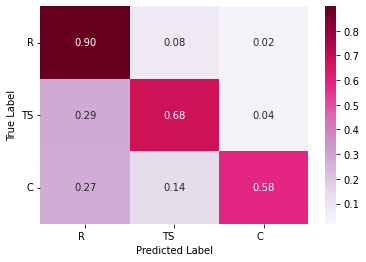

In [10]:
cm = confusion_matrix(forum_test.label_ids, forum_test.predictions.argmax(-1))
show_confusion_matrix(cm, normalized=True, class_names=["R", "TS", "C"])

### Classify synthetic data with confidence Intervals

In [3]:
gpt_train = pd.read_csv("synthetic_train_gpt_labels_as_qs.csv", index_col="Unnamed: 0")
gpt_test = pd.read_csv("synthetic_test_gpt_labels_as_qs.csv", index_col="Unnamed: 0")
sentences_train = gpt_train["Sentence"].to_list()
sentences_test = gpt_test["Sentence"].to_list()

In [8]:
splitted_train = np.array_split(sentences_train, 10)

In [21]:
splitted_train[0]

array([' Ich denke, ich habe mich schon immer ein bisschen zu viel gefühlt.',
       ' Ich finde es wichtig mein Gewicht zu reduzieren, da ich einige gesundheitliche Probleme habe.',
       ' Ich muss wieder zurück zu meinen Wurzeln gehen.', ...,
       ' Ich weiß einfach nicht, was ich tun soll.', ' Hallo!',
       ' Ich vermeide Fett, Zucker, Salz und Alkohol.'], dtype='<U256')

In [6]:
from transformers import TextClassificationPipeline

cuda = torch.device('cuda')
model = AutoModelForSequenceClassification.from_pretrained("classifs/forum_only/model", local_files_only=True).cuda()
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)

In [ ]:
label_0_scores = []
label_1_scores = []
label_2_scores = []

for entry in splitted_train:
    print(entry)
    with pipe.device_placement():
        torch.cuda.empty_cache()
        predictions_train = pipe(list(entry), truncation=True, batch_size=4)
        for entry in predictions_train:
            label_0_scores.append(entry[0]['score'])
            label_1_scores.append(entry[1]['score'])
            label_2_scores.append(entry[2]['score'])

In [19]:
#len(label_0_scores)
pred_train_df = pd.DataFrame({"Sentence": sentences_train, "0_R":label_0_scores, "1_TS": label_1_scores, "2_C": label_2_scores })

In [23]:
pred_train_df.to_csv("synthetic_train_predicted_confidence.csv")

In [4]:
splitted_test = np.array_split(sentences_test, 2)

In [7]:
label_0_scores = []
label_1_scores = []
label_2_scores = []

for entry in splitted_test:
    print(entry)
    with pipe.device_placement():
        torch.cuda.empty_cache()
        predictions_train = pipe(list(entry), truncation=True, batch_size=4)
        for entry in predictions_train:
            label_0_scores.append(entry[0]['score'])
            label_1_scores.append(entry[1]['score'])
            label_2_scores.append(entry[2]['score'])
    
pred_test_df = pd.DataFrame({"Sentence": sentences_test, "0_R":label_0_scores, "1_TS": label_1_scores, "2_C": label_2_scores })

[' Ich wünsche mir mehr Kontrolle über meine Ernährung.'
 ' Ich habe mich ein wenig gesünder ernährt.'
 ' Welche Möglichkeiten siehst du, um etwas gegen dieses Gefühl der Anstrengung zu unternehmen?'
 ...
 ' Ich würde gerne wieder mehr Sport treiben, aber ich weiß nicht, wie ich das anfangen soll.'
 ' Ich müsste mehr Zeit haben um mich zu bewegen.'
 ' Ich habe einige Wochen zuvor begonnen, meine Ernährung umzustellen.']
[' Ich bin so müde von der ganzen Arbeit, die ich in meinen Körper investiere und ich möchte endlich Ergebnisse sehen.'
 ' Ich möchte gesund leben und mich auch so fühlen.'
 ' Auch die Geschwindigkeit, mit der ich esse, könnte ich einschränken.'
 ... ' Hallo!' ' Meine Ernährung hat sich sehr verbessert.'
 ' Ich könnte mein Essen einfach nur ansehen und dann wüsste ich, wie viel ich esse.']


In [10]:
pred_test_df.to_csv("synthetic_test_predicted_confidence.csv")

NameError: name 'pred_test_df' is not defined

In [4]:
forum_vals, forum_trains = load_and_tokenize_training_set("sublabels/train_sublabels_synthetic_noR.csv")
training_args = TrainingArguments("test", evaluation_strategy="epoch")

for i in range(2):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
    trainer = Trainer(model=model, args=training_args, train_dataset=forum_trains[i], eval_dataset=forum_vals[i], compute_metrics=compute_metrics)
    trainer.train()
    forum_preds = load_predict_testset("sublabels/sublabels_forum_test_noR.csv", trainer=trainer)
    synthetic_preds = load_predict_testset("sublabels/test_sublabels_synthetic_noR.csv", trainer=trainer)
    print("Forum: ")
    print(compute_test_metrics(forum_preds, 'macro'))
    print("Synthetic: ")
    print(compute_test_metrics(synthetic_preds, 'macro'))

Using custom data configuration default-72b5b6a0301140a8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-72b5b6a0301140a8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/10 [00:00<?, ?it/s]

Using custom data configuration default-72b5b6a0301140a8
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-72b5b6a0301140a8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

test


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.817654,0.783783,0.631480,0.621836,0.633728,0.622887
2,0.709786,0.760802,0.664467,0.664638,0.680386,0.665189


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

wandb: WARNING Step must only increase in log calls.  Step 3500 < 3585; dropping {'train/loss': 0.54496630859375, 'train/learning_rate': 1.1446119486320492e-06, 'train/epoch': 2.931323283082077}.
wandb: WARNING Step must only increase in log calls.  Step 3582 < 3585; dropping {'eval/loss': 0.9245823621749878, 'eval/accuracy': 0.6365348399246704, 'eval/f1': 0.6317549258129733, 'eval/precision': 0.6393461699061054, 'eval/recall': 0.6392218454953957, 'train/epoch': 3.0}.
wandb: WARNING Step must only increase in log calls.  Step 3582 < 3585; dropping {'train/total_flos': 9602768188588032, 'train/epoch': 3.0}.
Using custom data configuration default-ac5cb7352c4ec37c
Reus

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-ac5cb7352c4ec37c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-32020e421c50ad77.arrow


Using custom data configuration default-a69c280ab7593910
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-a69c280ab7593910/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-a69c280ab7593910/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-781474f715c0055e.arrow


Forum: 
{'accuracy': 0.4973821989528796, 'f1': 0.4968102332403128, 'precision': 0.5303703703703704, 'recall': 0.5557579515799809}
Synthetic: 
{'accuracy': 0.6661642803315749, 'f1': 0.664107899905828, 'precision': 0.6710721623607286, 'recall': 0.6677061986680758}
